# Rozwiązanie zadania rekrutacyjnego

## Uwagi do rozwiązania

0. Przyjąłem założenie, że otrzymane dane zawierają reprezentatywną grupę klientów, na podstawie której można tworzyć dalsze rekomendacje i zalecenia.
1. Długość pomiędzy przedłużeniem umowy, a ostanim kontaktem - ilość dni została zmieniona z ustalonych 30, na pominięcie tego filtrowania ze względu na małą próbkę danych dla okresu 30 dni (50 obserwacji dla 30 dni) -> jeśli klient przedłużył umowę jest to uznane za sukces kampanii
2. Pominięto sprawdzanie wpływu godziny otrzymania kontaktu na przedłużenie umowy oraz dat kontaktów ze strony sieci na przedłużenie umowy (losowa generacja)
3. TeleOut przy zawieszonej polityce kontaktów potraktowano jako telefon poza dotychczasową polityką kontaktów (w danych zawieszona polityka kontaktów wkazuje na zerowy kontakt ze strony sieci (Teleout #1, contact sms #1 i contact TeleOut #2 są puste gdy communication suspended = yes))

In [75]:
#import bibliotek i wczytanie danych
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import missingno as msno
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px



In [2]:
# !ls ../data/raw/
df = pd.read_excel('../data/raw/zadanie rekrutacyjne G.Bałanda.xlsx')

### Zobaczmy jak wyglądają dane

In [3]:
df

,Customer id,customer value Jan-Mar23,expiration date,communication suspended,contact TeleOut #1,contact sms #1,contact TeleOut #2,Retention date,Retention Channel,Commission,value after retention,Resignation channel,Resignation date
0,Cust #1,78.194893,2023-10-07 04:06:42.361,no,2023-05-18 21:33:46.638,2023-06-25 01:53:00.821,NaT,NaT,NaN,NaN,NaN,NaN,NaT
1,Cust #2,83.686783,2023-09-22 13:33:04.879,no,2023-05-22 02:30:22.388,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaT
2,Cust #3,81.190345,2023-09-12 22:26:36.266,no,2023-05-07 20:51:31.651,NaT,NaT,2023-09-22 01:40:35.814,Shop,124.853268,94.097896,NaN,NaT
3,Cust #4,90.560638,2023-10-09 12:37:59.097,no,NaT,2023-06-17 10:42:42.513,2023-08-08 16:53:44.974,NaT,NaN,NaN,NaN,Shop,2023-10-07 17:07:03.206
4,Cust #5,87.557485,2023-10-01 07:13:08.946,no,NaT,2023-06-07 19:21:56.337,2023-07-25 18:28:08.923,2023-09-14 18:11:34.154,TeleIn,120.179543,93.376548,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2265,Cust #2266,77.352726,2023-09-15 09:26:09.272,no,NaT,2023-06-03 12:14:32.542,2023-07-11 23:25:29.600,2023-09-07 06:55:08.726,Shop,184.060584,67.782142,NaN,NaT
2266,Cust #2267,79.706599,2023-09-27 03:21:17.987,no,NaT,2023-06-04 14:33:41.745,2023-06-29 18:05:54.950,2023-09-25 23:02:24.922,TeleOut,145.425290,88.611057,NaN,NaT
2267,Cust #2268,99.004738,2023-09-18 03:26:17.023,no,NaT,2023-05-28 03:10:17.334,2023-06-24 02:12:33.228,2023-09-14 05:18:38.623,www,110.562889,110.831920,NaN,NaT
2268,Cust #2269,83.657607,2023-09-14 13:40:10.104,no,NaT,2023-05-23 04:41:17.262,2023-07-11 10:27:22.950,2023-09-28 00:22:38.555,TeleOut,128.953957,95.197093,NaN,NaT


Zbiór danych ma 2270 obserwacji i 13 zmiennych

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2270 entries, 0 to 2269
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Customer id               2270 non-null   object        
 1   customer value Jan-Mar23  2270 non-null   float64       
 2   expiration date           2270 non-null   datetime64[ns]
 3   communication suspended   2270 non-null   object        
 4   contact TeleOut #1        955 non-null    datetime64[ns]
 5   contact sms #1            493 non-null    datetime64[ns]
 6   contact TeleOut #2        771 non-null    datetime64[ns]
 7   Retention date            1274 non-null   datetime64[ns]
 8   Retention Channel         1274 non-null   object        
 9   Commission                1274 non-null   float64       
 10  value after retention     1274 non-null   float64       
 11  Resignation channel       375 non-null    object        
 12  Resignation date    

<Axes: >

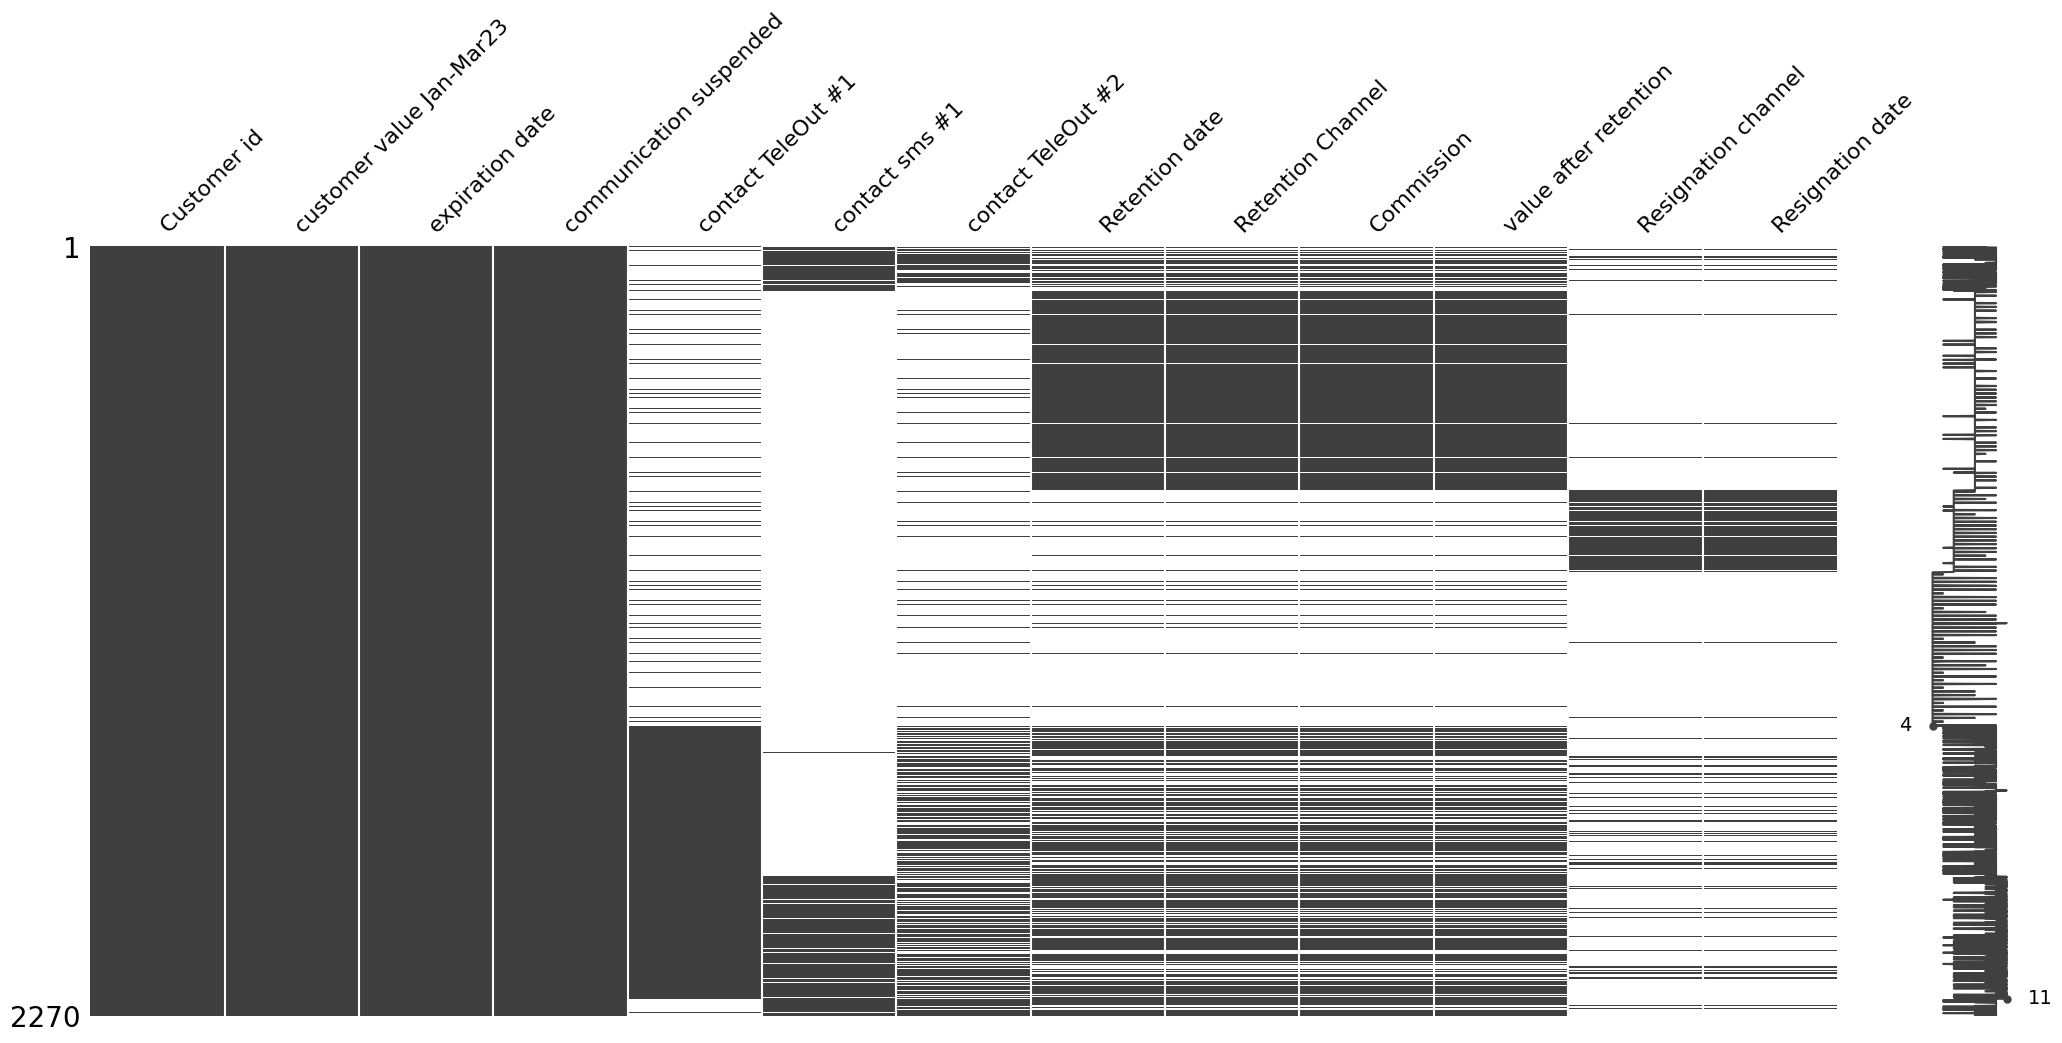

In [4]:
# sprawdzanie brakujących danych
df.info()
msno.matrix(df)

### Oczyszczenie danych


<Axes: >

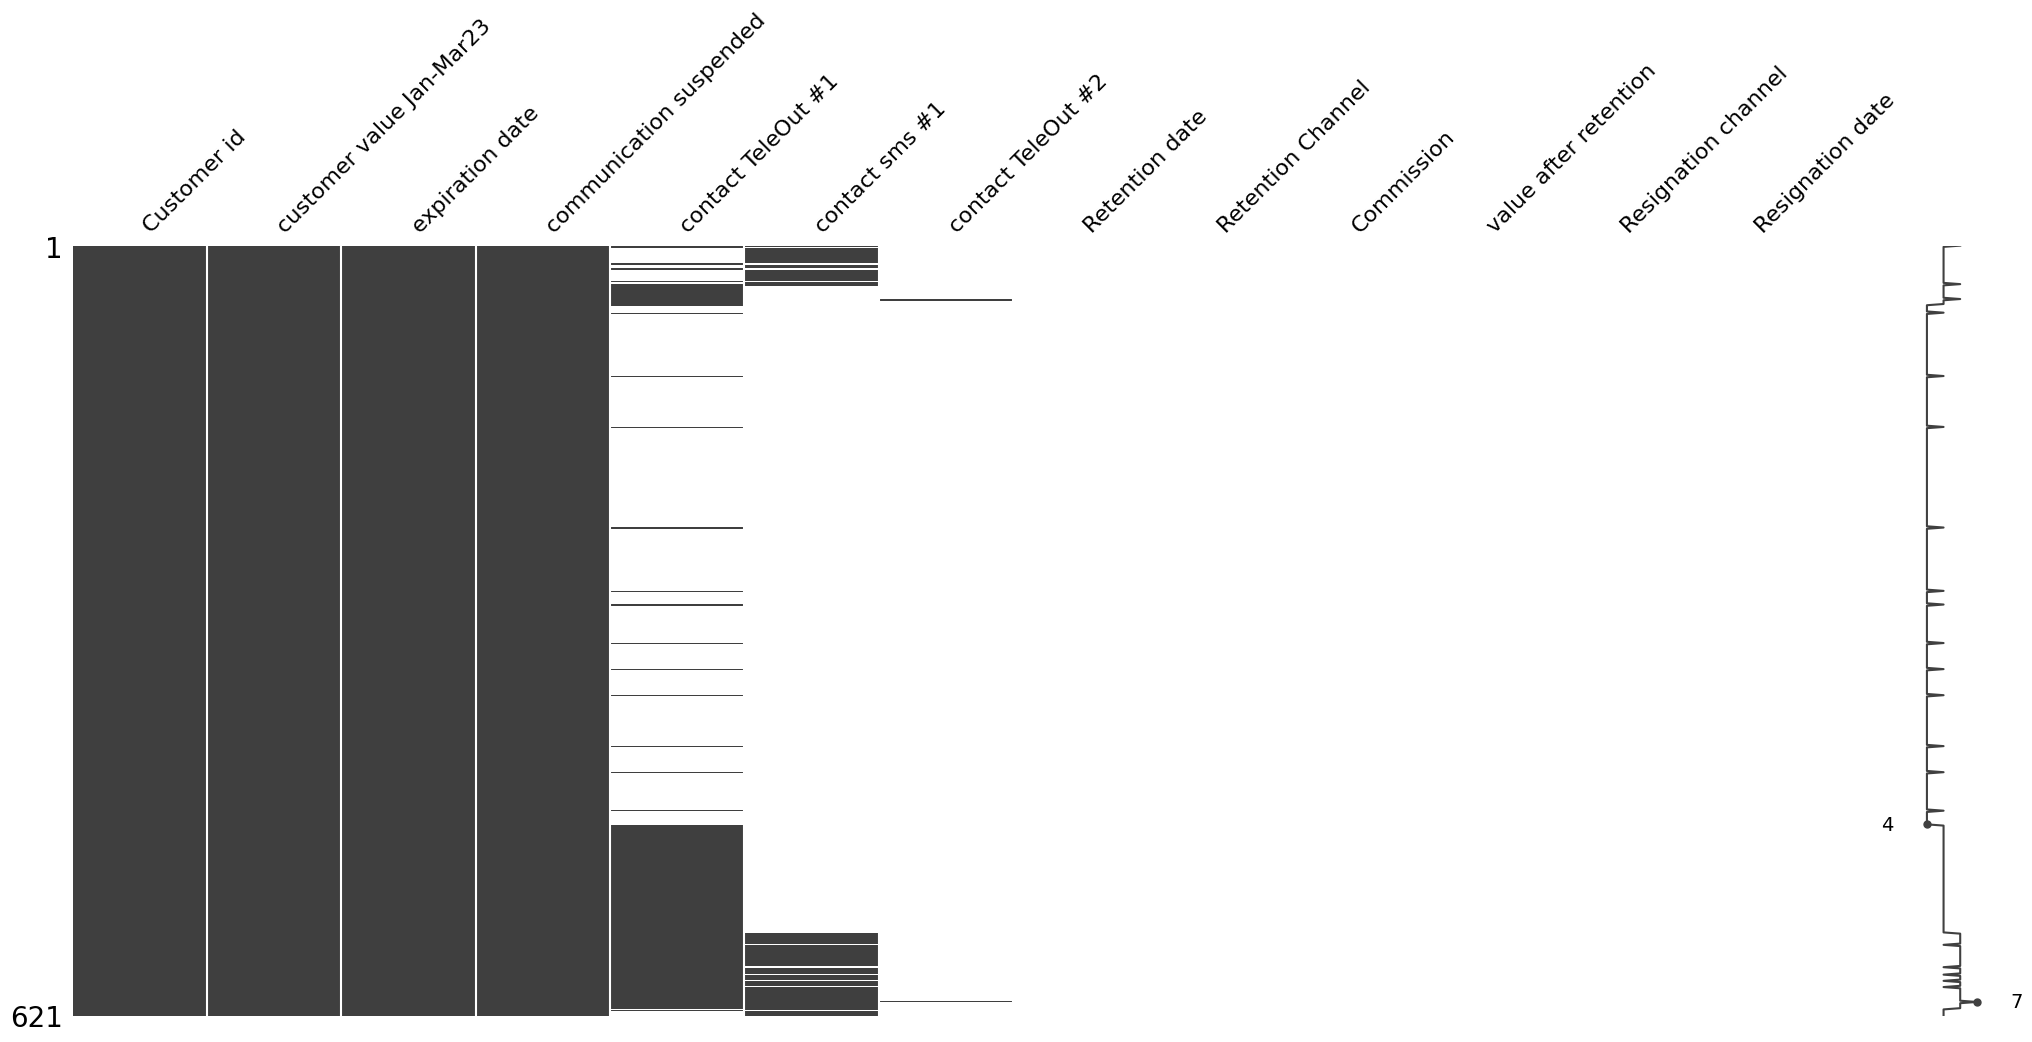

In [5]:
msno.matrix(df[df[['Retention date', 'Resignation date']].isna().all(axis=1)])

Powyższa próbka danych (621 obserwacji - ok 27%)- klientów którzy jeszcze nie przedłużyli umowy, ale jej również jeszcze nie wypowiedzieli będzie nam potrzebna w późniejszej analizie, póki co usuńmy ją do pierwotnej analizy.

In [6]:
# Usunięcie obserwacji, gdzie brak informacji o przedłużeniu lub wypowiedzeniu umowy
df = df.dropna(subset=['Retention date', 'Resignation date'], how='all').reset_index(drop=True)
df

,Customer id,customer value Jan-Mar23,expiration date,communication suspended,contact TeleOut #1,contact sms #1,contact TeleOut #2,Retention date,Retention Channel,Commission,value after retention,Resignation channel,Resignation date
0,Cust #3,81.190345,2023-09-12 22:26:36.266,no,2023-05-07 20:51:31.651,NaT,NaT,2023-09-22 01:40:35.814,Shop,124.853268,94.097896,NaN,NaT
1,Cust #4,90.560638,2023-10-09 12:37:59.097,no,NaT,2023-06-17 10:42:42.513,2023-08-08 16:53:44.974,NaT,NaN,NaN,NaN,Shop,2023-10-07 17:07:03.206
2,Cust #5,87.557485,2023-10-01 07:13:08.946,no,NaT,2023-06-07 19:21:56.337,2023-07-25 18:28:08.923,2023-09-14 18:11:34.154,TeleIn,120.179543,93.376548,NaN,NaT
3,Cust #6,72.117822,2023-09-27 11:06:06.727,no,NaT,2023-06-12 20:20:07.400,2023-07-06 16:31:40.575,2023-10-02 06:57:45.716,TeleOut,121.251163,57.728364,NaN,NaT
4,Cust #7,97.630542,2023-10-07 16:10:04.497,no,NaT,2023-06-28 21:55:13.524,2023-07-16 22:38:47.663,2023-09-08 14:37:06.399,Shop,141.326402,108.626538,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,Cust #2266,77.352726,2023-09-15 09:26:09.272,no,NaT,2023-06-03 12:14:32.542,2023-07-11 23:25:29.600,2023-09-07 06:55:08.726,Shop,184.060584,67.782142,NaN,NaT
1645,Cust #2267,79.706599,2023-09-27 03:21:17.987,no,NaT,2023-06-04 14:33:41.745,2023-06-29 18:05:54.950,2023-09-25 23:02:24.922,TeleOut,145.425290,88.611057,NaN,NaT
1646,Cust #2268,99.004738,2023-09-18 03:26:17.023,no,NaT,2023-05-28 03:10:17.334,2023-06-24 02:12:33.228,2023-09-14 05:18:38.623,www,110.562889,110.831920,NaN,NaT
1647,Cust #2269,83.657607,2023-09-14 13:40:10.104,no,NaT,2023-05-23 04:41:17.262,2023-07-11 10:27:22.950,2023-09-28 00:22:38.555,TeleOut,128.953957,95.197093,NaN,NaT


Dane są ustrukturyzowane i oczyszczone. W zbiorze pozostało 1649 obserwacji, możemy przejść do ich analizy.

## Analiza eksploracyjna danych

Statystyka opisowa dla customer value, commission

In [7]:
df[['customer value Jan-Mar23', 'value after retention', 'Commission']].describe()
df.shape

(1649, 13)

Podsumowanie:

**customer value Jan-Mar23**

1. Odchylenie standardowe 8.65 wskazuje na umiarkowaną zmienność wartości rachunków.
2. Rachunki od 70.02 o 99.99 to wąski zakres rachunków w tym okresie
3. Środkowa połowa wartości rachunków zbliżona jest do średniej jak i mediany (zakres rachunków 25 do 75 percentyla)

**value after retention**

1. Średnia wartość rachunku jest zbliżona do średniej przed przełużeniem umowy
2. Odchylenie standarowe - 12.05 jest większe niż przed przełużeniem umowy
3. Typowy rachunek jest również zbliżony do śreniej oraz mediany (zakres rachunków 25 do 75 percentyla)

**Commission**

1. Średnia wartość prowizji to 149.82 z odchyleniem stanarowym 29.39, co wskazuje na pewną zmienność w wypłacanych prowizjach
2. Zakres wypłacanych prowizji jest szeroki od 100.08 do 199.99
3. Połowa prowizji jest w przedziale 124.79 do 175.37, co znaczy że może znacznie się różnić od średniej.


Zobaczmy jak dane customer value wyglądają przed i po przedłużeniu umowy

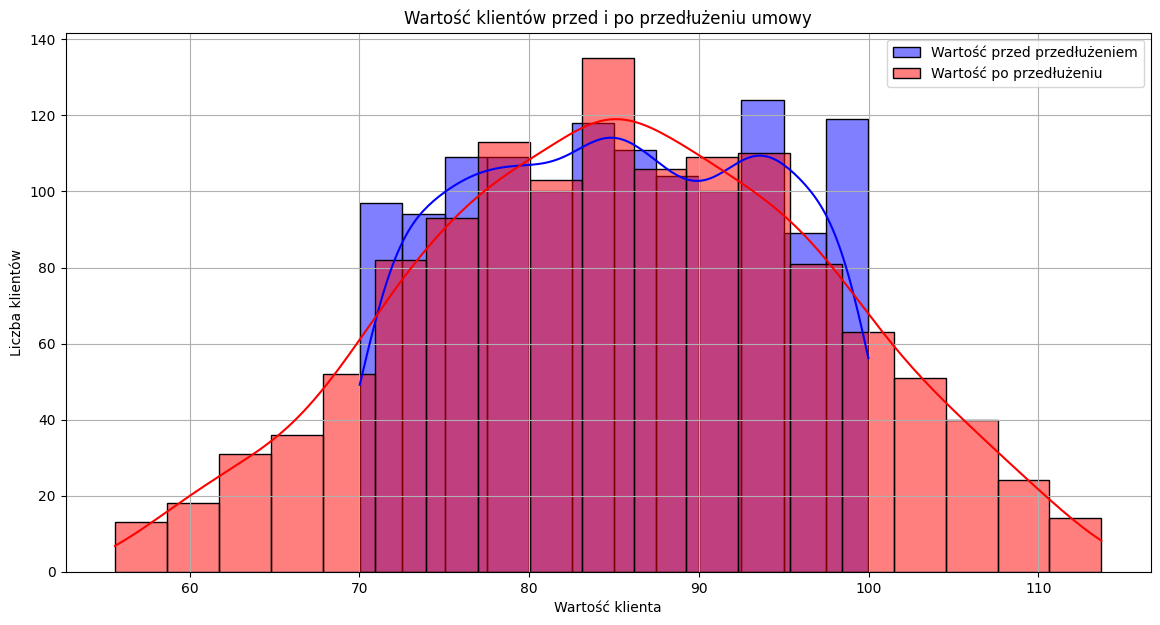

In [8]:
import seaborn as sns

df_retained = df.dropna(subset=['Retention date'])

plt.figure(figsize=(14, 7))
sns.histplot(df_retained['customer value Jan-Mar23'], label='Wartość przed przedłużeniem', color='blue', kde=True)
sns.histplot(df_retained['value after retention'], label='Wartość po przedłużeniu', color='red', kde=True)
plt.title('Wartość klientów przed i po przedłużeniu umowy')
plt.xlabel('Wartość klienta')
plt.ylabel('Liczba klientów')
plt.legend()
plt.grid(True)
plt.show()


### Analiza danych klientów którzy przedłużyli umowę

In [9]:
# selekcja obserwacji klientów którzy przedłużyli umowę
df_ret = df.dropna(subset=['Retention date']).reset_index(drop=True)

In [10]:
df_ret

,Customer id,customer value Jan-Mar23,expiration date,communication suspended,contact TeleOut #1,contact sms #1,contact TeleOut #2,Retention date,Retention Channel,Commission,value after retention,Resignation channel,Resignation date
0,Cust #3,81.190345,2023-09-12 22:26:36.266,no,2023-05-07 20:51:31.651,NaT,NaT,2023-09-22 01:40:35.814,Shop,124.853268,94.097896,NaN,NaT
1,Cust #5,87.557485,2023-10-01 07:13:08.946,no,NaT,2023-06-07 19:21:56.337,2023-07-25 18:28:08.923,2023-09-14 18:11:34.154,TeleIn,120.179543,93.376548,NaN,NaT
2,Cust #6,72.117822,2023-09-27 11:06:06.727,no,NaT,2023-06-12 20:20:07.400,2023-07-06 16:31:40.575,2023-10-02 06:57:45.716,TeleOut,121.251163,57.728364,NaN,NaT
3,Cust #7,97.630542,2023-10-07 16:10:04.497,no,NaT,2023-06-28 21:55:13.524,2023-07-16 22:38:47.663,2023-09-08 14:37:06.399,Shop,141.326402,108.626538,NaN,NaT
4,Cust #9,96.056376,2023-09-22 19:24:49.839,no,NaT,2023-06-19 05:50:23.875,2023-07-20 02:05:10.586,2023-09-24 08:49:00.894,TeleIn,129.936209,103.154549,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,Cust #2265,90.294486,2023-09-16 07:40:28.274,no,NaT,2023-05-26 07:05:55.776,2023-06-23 07:30:27.989,2023-09-10 00:24:28.720,TeleOut,108.825371,95.482185,NaN,NaT
1270,Cust #2266,77.352726,2023-09-15 09:26:09.272,no,NaT,2023-06-03 12:14:32.542,2023-07-11 23:25:29.600,2023-09-07 06:55:08.726,Shop,184.060584,67.782142,NaN,NaT
1271,Cust #2267,79.706599,2023-09-27 03:21:17.987,no,NaT,2023-06-04 14:33:41.745,2023-06-29 18:05:54.950,2023-09-25 23:02:24.922,TeleOut,145.425290,88.611057,NaN,NaT
1272,Cust #2268,99.004738,2023-09-18 03:26:17.023,no,NaT,2023-05-28 03:10:17.334,2023-06-24 02:12:33.228,2023-09-14 05:18:38.623,www,110.562889,110.831920,NaN,NaT


In [11]:
df_ret['communication suspended'].value_counts()

communication suspended
no     744
yes    530
Name: count, dtype: int64

Większość klientów (744, 58%) przedłużyła umowę, gdy komunikacja nie była wstrzymana. Znaczna liczba klientów (530, 42%) przedłużyła umowę mimo wstrzymanej komunikacji. Różnica wskazuje na to, że wstrzymanie komunikacji lub jej utrzymanie może być skuteczne w różnych przypadkach.

**Spośród klientów przedłużających umowę, większość z nich otrzymywała kontakt zgodnie z dotychczasową polityką**

Zanim przejdziemy dalej, zobaczmy jeszcze jak ten podział wygląda dla klientów którzy nie przedłużyli umowy

In [12]:
df_no_ret = df.dropna(subset=['Resignation date']).reset_index(drop=True)
df_no_ret['communication suspended'].value_counts()

communication suspended
yes    217
no     158
Name: count, dtype: int64

Spośród klientów którzy nie przedłużyli umowy, większość miała wstrzymaną politykę kontaktów (217 vs 158). Biorąc pod uwagę, że w przypadku przedłużenia umowy występuje odwrortna zależność (większość przedłużających umowę, to klienci z utrzymaną dotychczasową polityką kontaktów), może to sugerować iż wstryzmanie polityki kontaktów wpływa negatywnie na przedłużenie umów. 

**Klienci z którymi nie prowadzono komunikacji zgodnie z dotychczasową polityką, byli mniej skłonni do przedłużenia umowy.**

In [13]:
df_ret['number_of_communications'] = df_ret[['contact TeleOut #1', 'contact TeleOut #2', 'contact sms #1']].notna().sum(axis=1)
comm_dist = df_ret.groupby(['communication suspended', 'number_of_communications']).size().reset_index(name='Count')
comm_dist


,communication suspended,number_of_communications,Count
0,no,1,84
1,no,2,477
2,no,3,183
3,yes,0,530


Dla klientów przedłużających umowę w przypadku zawieszenia dotychczasowej polityki nie wystąpiło żadne nawiązanie kontaktu. Gdy wystąpił jakikolwiek kontakt, nastąpiło to według dotychczasowej polityki.

Zobaczmy jak wygląda średni rachunek przed i po przedłużeniu umowy w zależności od kanału retencji

Zobaczmy jak wygląda prowizja w zależności od tego czy komunikacja była prowadzona według dotychczasowej polityki

In [14]:
df_ret.groupby('communication suspended')['Commission'].mean().reset_index()


,communication suspended,Commission
0,no,150.824307
1,yes,148.417974


Przy zawieszonej polityce komunikacji średnia wypłacana prowizja była niewiele mniejsza, zobaczmy jak się to przedstawia z podziałem w zależności od kanału retencji

In [15]:
df_ret.groupby(['Retention Channel', 'communication suspended', ])['Commission'].mean().reset_index()

,Retention Channel,communication suspended,Commission
0,Shop,no,150.770302
1,Shop,yes,149.816262
2,TeleIn,no,152.518432
3,TeleIn,yes,150.346413
4,TeleOut,no,147.394852
5,TeleOut,yes,147.101739
6,www,no,152.965376
7,www,yes,145.948929


Przy zawieszonej polityce kontaktów średnia prowizja jest podobna dla kanału TeleOut, dla kanałów Shop i TeleIn jest trochę niższa, dla kanału www jest znacząco niższa.
TeleOut - wskazuje na nawiązanie kontaktu przy zawieszonej polityce kontaktów (0 kontaktów ze strony sieci), spójrzmy konkretnie na te przykłady

In [16]:
df_ret = df.dropna(subset=['Retention date']).reset_index(drop=True)
df_ret['number_of_communications'] = df_ret[['contact TeleOut #1', 'contact TeleOut #2', 'contact sms #1']].notna().sum(axis=1)
df_ret[(df_ret['Retention Channel'] == 'TeleOut') & (df_ret['communication suspended'] == 'yes')]

,Customer id,customer value Jan-Mar23,expiration date,communication suspended,contact TeleOut #1,contact sms #1,contact TeleOut #2,Retention date,Retention Channel,Commission,value after retention,Resignation channel,Resignation date,number_of_communications
82,Cust #135,78.188276,2023-10-09 19:18:10.392,yes,NaT,NaT,NaT,2023-09-27 18:33:32.621,TeleOut,174.887587,73.676812,NaN,NaT,0
90,Cust #143,92.566075,2023-09-21 21:14:28.782,yes,NaT,NaT,NaT,2023-09-03 14:29:05.254,TeleOut,196.289367,79.443515,NaN,NaT,0
103,Cust #156,80.903894,2023-10-04 13:57:41.352,yes,NaT,NaT,NaT,2023-09-10 12:17:53.134,TeleOut,100.247488,70.151478,NaN,NaT,0
108,Cust #162,86.102496,2023-10-03 15:05:22.939,yes,NaT,NaT,NaT,2023-10-12 18:59:34.055,TeleOut,150.129675,89.642068,NaN,NaT,0
123,Cust #177,86.456103,2023-10-10 02:26:55.364,yes,NaT,NaT,NaT,2023-08-30 07:15:05.515,TeleOut,150.104368,96.494601,NaN,NaT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,Cust #709,74.088637,2023-10-07 18:59:56.824,yes,NaT,NaT,NaT,2023-08-30 16:55:59.452,TeleOut,100.538149,75.507062,NaN,NaT,0
641,Cust #715,81.434497,2023-09-22 00:49:39.616,yes,NaT,NaT,NaT,2023-09-17 05:25:23.510,TeleOut,141.805681,73.578578,NaN,NaT,0
642,Cust #716,97.092510,2023-09-19 05:56:11.353,yes,NaT,NaT,NaT,2023-08-06 07:51:56.907,TeleOut,140.509685,93.655062,NaN,NaT,0
643,Cust #717,97.128568,2023-10-09 08:05:18.093,yes,NaT,NaT,NaT,2023-10-02 14:28:49.367,TeleOut,153.279563,101.830890,NaN,NaT,0


Jest to 129 przypadków - na potrzeby rozwiązania zadania przyjmuję, że był to telefon ustalony z klientem (przy podpisaniu poprzedniej umowy, jakiejkolwiek innej), lub telefon od sieci podczas którego przedłużono od razu umowę, poza dotychczasową polityką kontaktów

Zobaczmy teraz jak wygląda Customer Value przed przedłużeniem umowy oraz po przedłużeniu w zależności od polityki kontaktów.

In [17]:
customer_value_by_suspended = df_ret.groupby('communication suspended').agg(
    avg_value_before=('customer value Jan-Mar23', 'mean'),
    avg_value_after=('value after retention', 'mean'),
    avg_commission=('Commission', 'mean')
).reset_index()
customer_value_by_suspended['difference'] = customer_value_by_suspended['avg_value_after'] - customer_value_by_suspended['avg_value_before']
customer_value_by_suspended

,communication suspended,avg_value_before,avg_value_after,avg_commission,difference
0,no,85.183449,85.400753,150.824307,0.217303
1,yes,85.326933,85.417211,148.417974,0.090278


Różnica w wartości klienta pomiędzy rachunkiem przed przedłużeniem umowy a po jest większa w grupie która nie miała wstrzymanej polityki komunikacji.

Rozbijmy ten podział w zależności od kanału retencji

In [18]:
customer_value_by_suspended_channel = df_ret.groupby(['Retention Channel', 'communication suspended']).agg(
    avg_value_before=('customer value Jan-Mar23', 'mean'),
    avg_value_after=('value after retention', 'mean')
).reset_index()

customer_value_by_suspended_channel['difference'] = customer_value_by_suspended_channel['avg_value_after'] - customer_value_by_suspended_channel['avg_value_before']
customer_value_by_suspended_channel


,Retention Channel,communication suspended,avg_value_before,avg_value_after,difference
0,Shop,no,85.805407,85.346845,-0.458562
1,Shop,yes,85.839833,85.202856,-0.636977
2,TeleIn,no,84.875980,85.559256,0.683276
3,TeleIn,yes,84.962652,85.415615,0.452962
4,TeleOut,no,85.075434,84.115908,-0.959526
5,TeleOut,yes,84.469066,84.499954,0.030887
6,www,no,85.033042,86.851972,1.818930
7,www,yes,86.056856,86.660539,0.603682


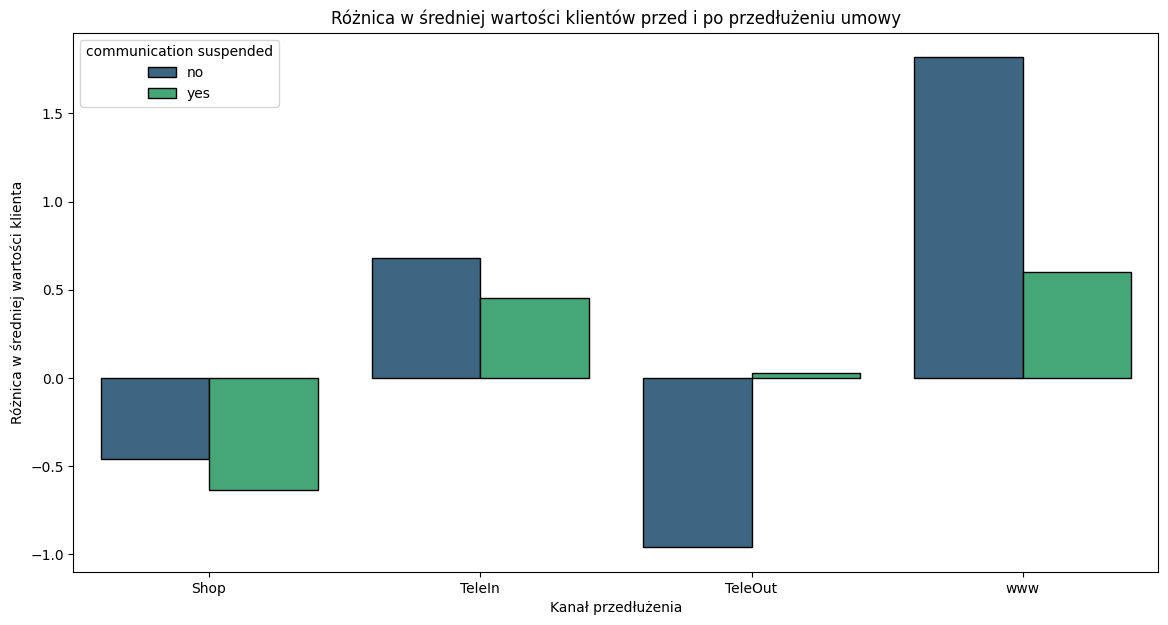

In [19]:
plt.figure(figsize=(14, 7))
sns.barplot(x='Retention Channel', y='difference', hue='communication suspended', data=customer_value_by_suspended_channel, palette='viridis', edgecolor='black')
plt.title('Różnica w średniej wartości klientów przed i po przedłużeniu umowy')
plt.xlabel('Kanał przedłużenia')
plt.ylabel('Różnica w średniej wartości klienta')
plt.legend(title='communication suspended')
plt.show()

1. Kanał TeleIn i www wykazują wzrost wartości klienta po przedłużeniu umowy, niezależnie od tego czy polityka komunikacji została wstrzymana czy nie.
2. Kanały Sklep i TeleOut notują obniżenie wartości klienta po przedłużeniu umowy, zwłaszcza gdy polityka komunikacji została wstrzymana.
3. Kanał www osiągnął najwyższy wzrost wartości klienta po przedłużeniu umowy, co sugeruje jego efektywność w utrzymaniu klientów.
4. Wstrzymanie komunikacji nie zawsze ma negatywny wpływ na wartość klienta po przedłużeniu umowy, co może sugerować,
    że wartość komunikacji może różnić się w zależności od kanału.

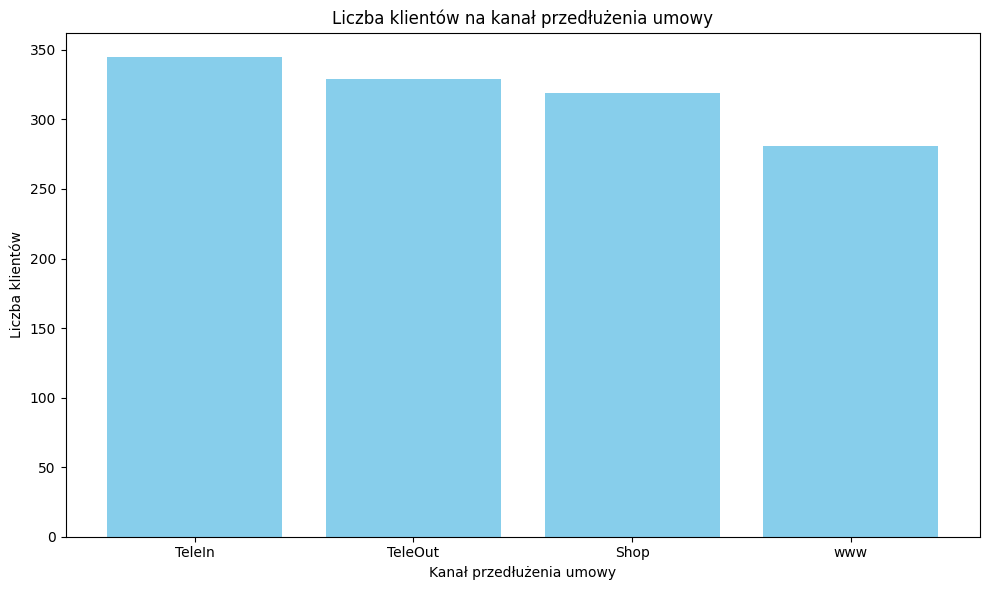

,Retention Channel,Number of Customers
0,TeleIn,345
1,TeleOut,329
2,Shop,319
3,www,281


In [20]:
customer_counts = df['Retention Channel'].value_counts().reset_index()
customer_counts.columns = ['Retention Channel', 'Number of Customers']

plt.figure(figsize=(10, 6))
plt.bar(customer_counts['Retention Channel'], customer_counts['Number of Customers'], color='skyblue')
plt.xlabel('Kanał przedłużenia umowy')
plt.ylabel('Liczba klientów')
plt.title('Liczba klientów na kanał przedłużenia umowy')
plt.tight_layout()
plt.show()

customer_counts


1. Najwięcej klientów przedłużyło umowę przez kanał TeleIn (345 klientów).
2. TeleOut i Sklep mają podobną liczbę klientów (odpowiednio 329 i 319 klientów).
3. Najmniej klientów przedłużyło umowę przez kanał www (281 klientów).

In [25]:
def count_non_empty(row):
    return sum(pd.notnull(row[col]) for col in ['contact TeleOut #1', 'contact sms #1', 'contact TeleOut #2'])

# Dodanie kolumny 'Number of Contacts'
df['Number of Contacts'] = df.apply(count_non_empty, axis=1)

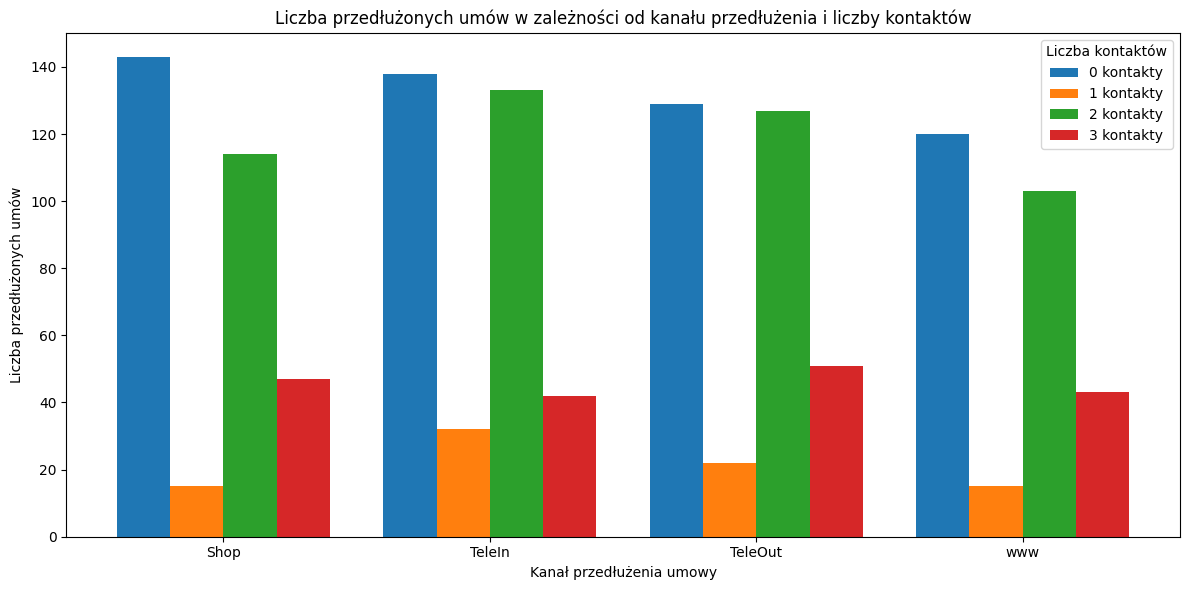

In [26]:
retained_customers = df[df['Retention date'].notna()]
retentions_by_channel_and_contacts = retained_customers.groupby(['Retention Channel', 'Number of Contacts']).size().reset_index(name='Count')

fig, ax = plt.subplots(figsize=(12, 6))

channels = retentions_by_channel_and_contacts['Retention Channel'].unique()
contacts = retentions_by_channel_and_contacts['Number of Contacts'].unique()

bar_width = 0.2
index = np.arange(len(channels))

for i, contact in enumerate(contacts):
    counts = retentions_by_channel_and_contacts[retentions_by_channel_and_contacts['Number of Contacts'] == contact]['Count']
    ax.bar(index + i * bar_width, counts, bar_width, label=f'{contact} kontakty')

ax.set_xlabel('Kanał przedłużenia umowy')
ax.set_ylabel('Liczba przedłużonych umów')
ax.set_title('Liczba przedłużonych umów w zależności od kanału przedłużenia i liczby kontaktów')
ax.set_xticks(index + bar_width * (len(contacts) - 1) / 2)
ax.set_xticklabels(channels)
ax.legend(title='Liczba kontaktów')

plt.tight_layout()
plt.show()

1. Klienci którzy otrzymali 0 kontaktów i 2 kontakty przedłużają umowy w podobny sposób jeśli chodzi o kanał retencji
2. Klienci którzy otrzymali 3 kontakty przedłużają umowy bez wyraźnych preferencji co do kanału
3. Klienci którzy otrzymali 1 kontakt najchętniej przedłużali umowy w kanale TeleIn a najmniej chętnie w Shop i www

In [43]:
retained_customers = df[df['Retention date'].notna()]

# Grupujemy dane i obliczamy średnie wartości
value_by_contacts = retained_customers.groupby('Number of Contacts').agg({
    'customer value Jan-Mar23': 'mean',
    'value after retention': 'mean'
}).reset_index()

# Tworzymy wykres
fig = go.Figure()

# Dodajemy słupki dla wartości przed retencją
fig.add_trace(go.Bar(
    x=[f"{contact} kontakty" for contact in value_by_contacts['Number of Contacts']],
    y=value_by_contacts['customer value Jan-Mar23'],
    name='Przed retencją',
    text=value_by_contacts['customer value Jan-Mar23'].round(2),
    textposition='auto',
    marker_color='lightblue'
))

# Dodajemy słupki dla wartości po retencji
fig.add_trace(go.Bar(
    x=[f"{contact} kontakty" for contact in value_by_contacts['Number of Contacts']],
    y=value_by_contacts['value after retention'],
    name='Po retencji',
    text=value_by_contacts['value after retention'].round(2),
    textposition='auto',
    marker_color='darkblue'
))

# Aktualizacja układu wykresu
fig.update_layout(
    title_text='Średnia wartość klienta przed i po retencji w zależności od liczby kontaktów',
    xaxis_title='Liczba kontaktów',
    yaxis_title='Średnia wartość klienta',
    barmode='group',
    height=600,
    width=1000
)

# Wyświetlenie wykresu
fig.show()

# Obliczenie procentowej zmiany
value_by_contacts['percent_change'] = ((value_by_contacts['value after retention'] - value_by_contacts['customer value Jan-Mar23']) / value_by_contacts['customer value Jan-Mar23'] * 100).round(2)

print("\nProcentowa zmiana wartości klienta:")
for _, row in value_by_contacts.iterrows():
    print(f"Liczba kontaktów: {row['Number of Contacts']}, Zmiana: {row['percent_change']}%")


Procentowa zmiana wartości klienta:
Liczba kontaktów: 0.0, Zmiana: 0.11%
Liczba kontaktów: 1.0, Zmiana: -0.09%
Liczba kontaktów: 2.0, Zmiana: 0.33%
Liczba kontaktów: 3.0, Zmiana: 0.21%


In [27]:
df

,Customer id,customer value Jan-Mar23,expiration date,communication suspended,contact TeleOut #1,contact sms #1,contact TeleOut #2,Retention date,Retention Channel,Commission,value after retention,Resignation channel,Resignation date,Days before Expiration,Number of Contacts
0,Cust #3,81.190345,2023-09-12 22:26:36.266,no,2023-05-07 20:51:31.651,NaT,NaT,2023-09-22 01:40:35.814,Shop,124.853268,94.097896,NaN,NaT,-10.0,1
1,Cust #4,90.560638,2023-10-09 12:37:59.097,no,NaT,2023-06-17 10:42:42.513,2023-08-08 16:53:44.974,NaT,NaN,NaN,NaN,Shop,2023-10-07 17:07:03.206,NaN,2
2,Cust #5,87.557485,2023-10-01 07:13:08.946,no,NaT,2023-06-07 19:21:56.337,2023-07-25 18:28:08.923,2023-09-14 18:11:34.154,TeleIn,120.179543,93.376548,NaN,NaT,16.0,2
3,Cust #6,72.117822,2023-09-27 11:06:06.727,no,NaT,2023-06-12 20:20:07.400,2023-07-06 16:31:40.575,2023-10-02 06:57:45.716,TeleOut,121.251163,57.728364,NaN,NaT,-5.0,2
4,Cust #7,97.630542,2023-10-07 16:10:04.497,no,NaT,2023-06-28 21:55:13.524,2023-07-16 22:38:47.663,2023-09-08 14:37:06.399,Shop,141.326402,108.626538,NaN,NaT,29.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,Cust #2266,77.352726,2023-09-15 09:26:09.272,no,NaT,2023-06-03 12:14:32.542,2023-07-11 23:25:29.600,2023-09-07 06:55:08.726,Shop,184.060584,67.782142,NaN,NaT,8.0,2
1645,Cust #2267,79.706599,2023-09-27 03:21:17.987,no,NaT,2023-06-04 14:33:41.745,2023-06-29 18:05:54.950,2023-09-25 23:02:24.922,TeleOut,145.425290,88.611057,NaN,NaT,1.0,2
1646,Cust #2268,99.004738,2023-09-18 03:26:17.023,no,NaT,2023-05-28 03:10:17.334,2023-06-24 02:12:33.228,2023-09-14 05:18:38.623,www,110.562889,110.831920,NaN,NaT,3.0,2
1647,Cust #2269,83.657607,2023-09-14 13:40:10.104,no,NaT,2023-05-23 04:41:17.262,2023-07-11 10:27:22.950,2023-09-28 00:22:38.555,TeleOut,128.953957,95.197093,NaN,NaT,-14.0,2


In [28]:
def count_contacts(row):
    return row[['contact TeleOut #1', 'contact sms #1', 'contact TeleOut #2']].notna().sum()

df['Number of Contacts'] = df.apply(count_contacts, axis=1)
retained_customers = df.dropna(subset=['value after retention'])

retained_customers.groupby('Number of Contacts').agg({
    'customer value Jan-Mar23': 'mean',
    'value after retention': 'mean'
}).reset_index()

,Number of Contacts,customer value Jan-Mar23,value after retention
0,0,85.326933,85.417211
1,1,84.441193,84.364501
2,2,85.272161,85.555539
3,3,85.292926,85.472950


1. Największy wzrost średniej wartości klienta po przedłużeniu umowy obserwowany jest dla klientów, którzy mieli 2 kontakty (wzrost z 85.27 do 85.56).
2. Dla klientów z 1 kontaktem średnia wartość po przedłużeniu nieznacznie spadła.
3. Ogólnie różnice w średnich wartościach przed i po przedłużeniu umowy są niewielkie, niezależnie od liczby kontaktów.

In [29]:
df['Days before Expiration'] = (df['expiration date'] - df['Retention date']).dt.days
retained_customers_days = df.dropna(subset=['Days before Expiration'])
retained_customers_days['Days before Expiration'].describe()

count    1274.000000
mean       14.801413
std        17.620882
min       -15.000000
25%        -1.000000
50%        15.000000
75%        30.000000
max        44.000000
Name: Days before Expiration, dtype: float64

Większość umów jest przedłużana w okresie od kilku dni po terminie do miesiąca przed końcem umowy, z medianą na poziomie 15 dni przed końcem umowy. 

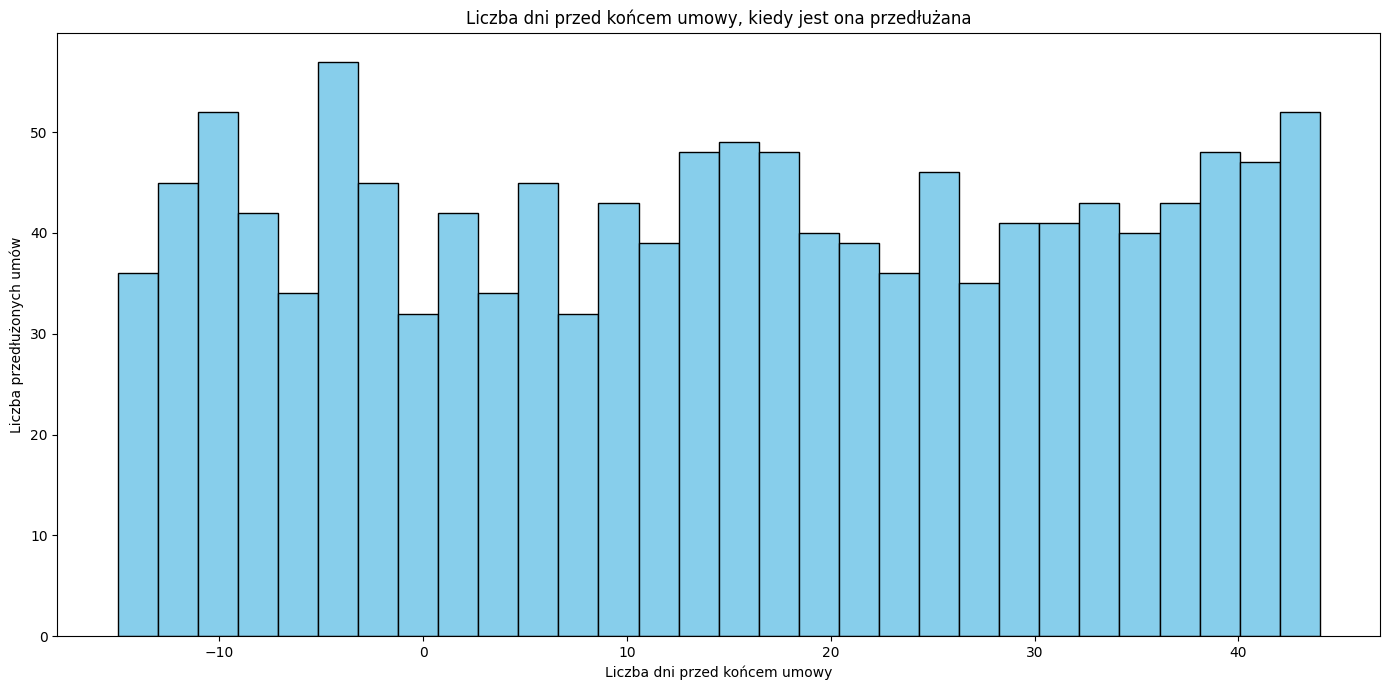

In [30]:
plt.figure(figsize=(14, 7))
plt.hist(retained_customers_days['Days before Expiration'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Liczba dni przed końcem umowy')
plt.ylabel('Liczba przedłużonych umów')
plt.title('Liczba dni przed końcem umowy, kiedy jest ona przedłużana')
plt.tight_layout()
plt.show()

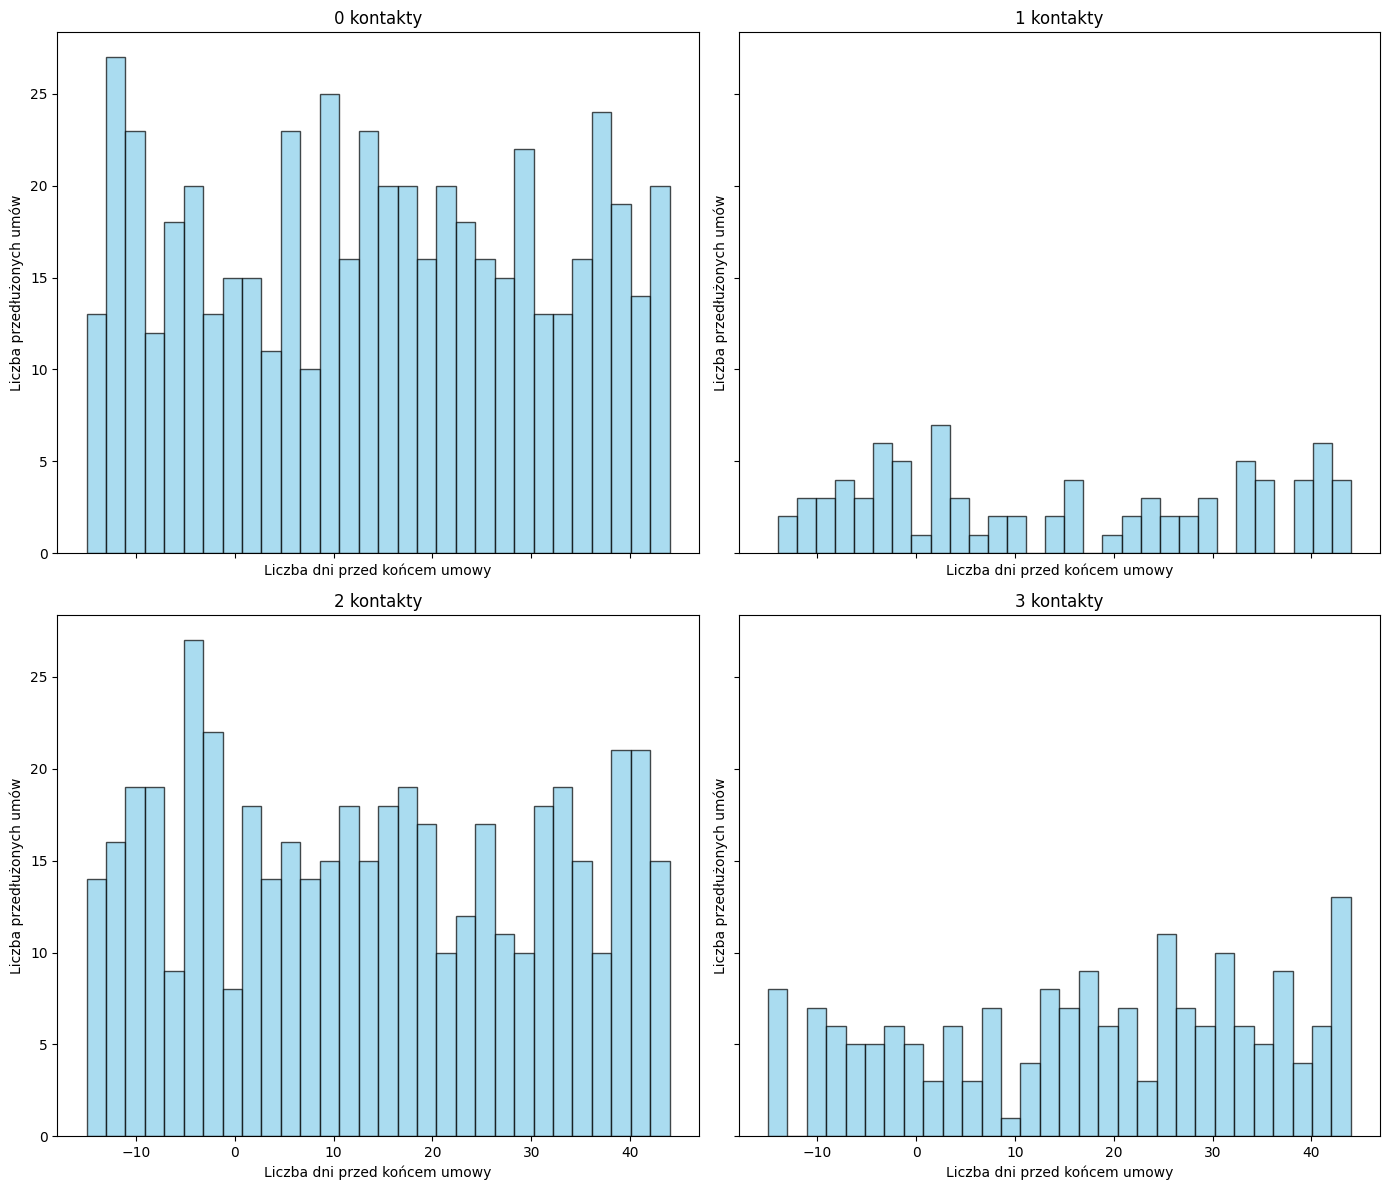

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, contact in enumerate(contacts):
    subset = retained_customers_days[retained_customers_days['Number of Contacts'] == contact]
    axes[i].hist(subset['Days before Expiration'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{contact} kontakty')
    axes[i].set_xlabel('Liczba dni przed końcem umowy')
    axes[i].set_ylabel('Liczba przedłużonych umów')

plt.tight_layout()
plt.show()

## Analiza klientów którzy nie przedłużyli umowy

In [32]:
df = pd.read_excel('../data/raw/zadanie rekrutacyjne G.Bałanda.xlsx')
df['Resigned'] = df['Resignation date'].notna()
df[df['Resigned'] == True].shape

(375, 14)

Mamy 375 klientów którzy zrezygnowali z przedłużenia umowy

In [33]:
df['Days to expire'] = (df['expiration date'] - df['Resignation date']).dt.days
resigned_customers_days = df.dropna(subset=['Days to expire'])
resigned_customers_days['Days to expire'].describe()

count    375.000000
mean       1.258667
std       21.739212
min      -45.000000
25%      -13.000000
50%        1.000000
75%       18.000000
max       44.000000
Name: Days to expire, dtype: float64

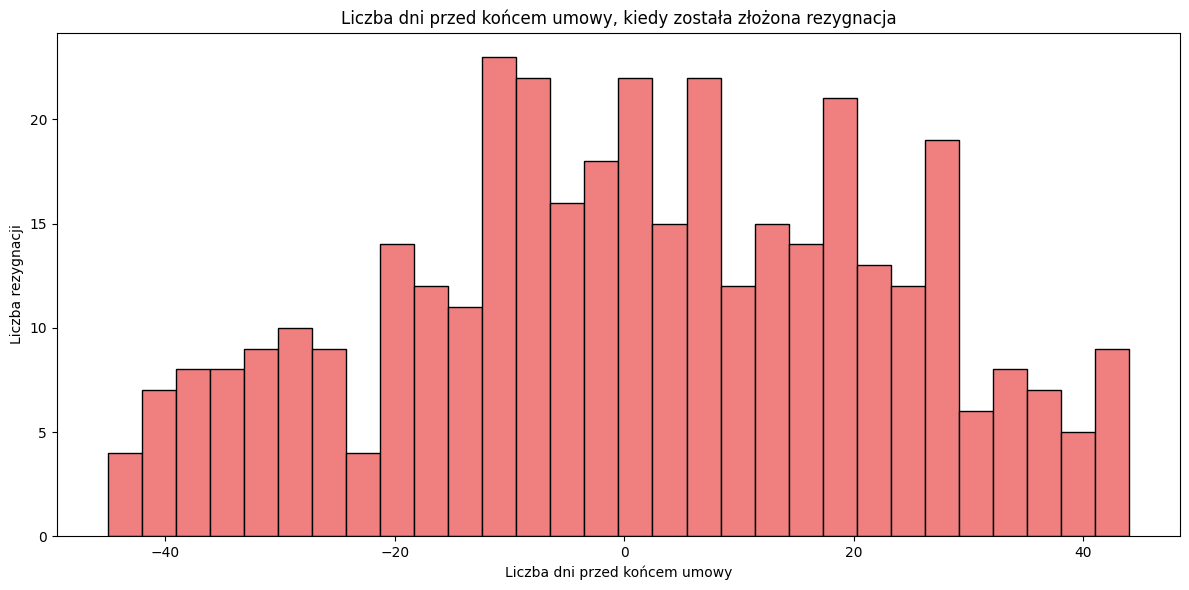

In [34]:
plt.figure(figsize=(12, 6))
plt.hist(resigned_customers_days['Days to expire'], bins=30, color='lightcoral', edgecolor='black')
plt.xlabel('Liczba dni przed końcem umowy')
plt.ylabel('Liczba rezygnacji')
plt.title('Liczba dni przed końcem umowy, kiedy została złożona rezygnacja')
plt.tight_layout()
plt.show()

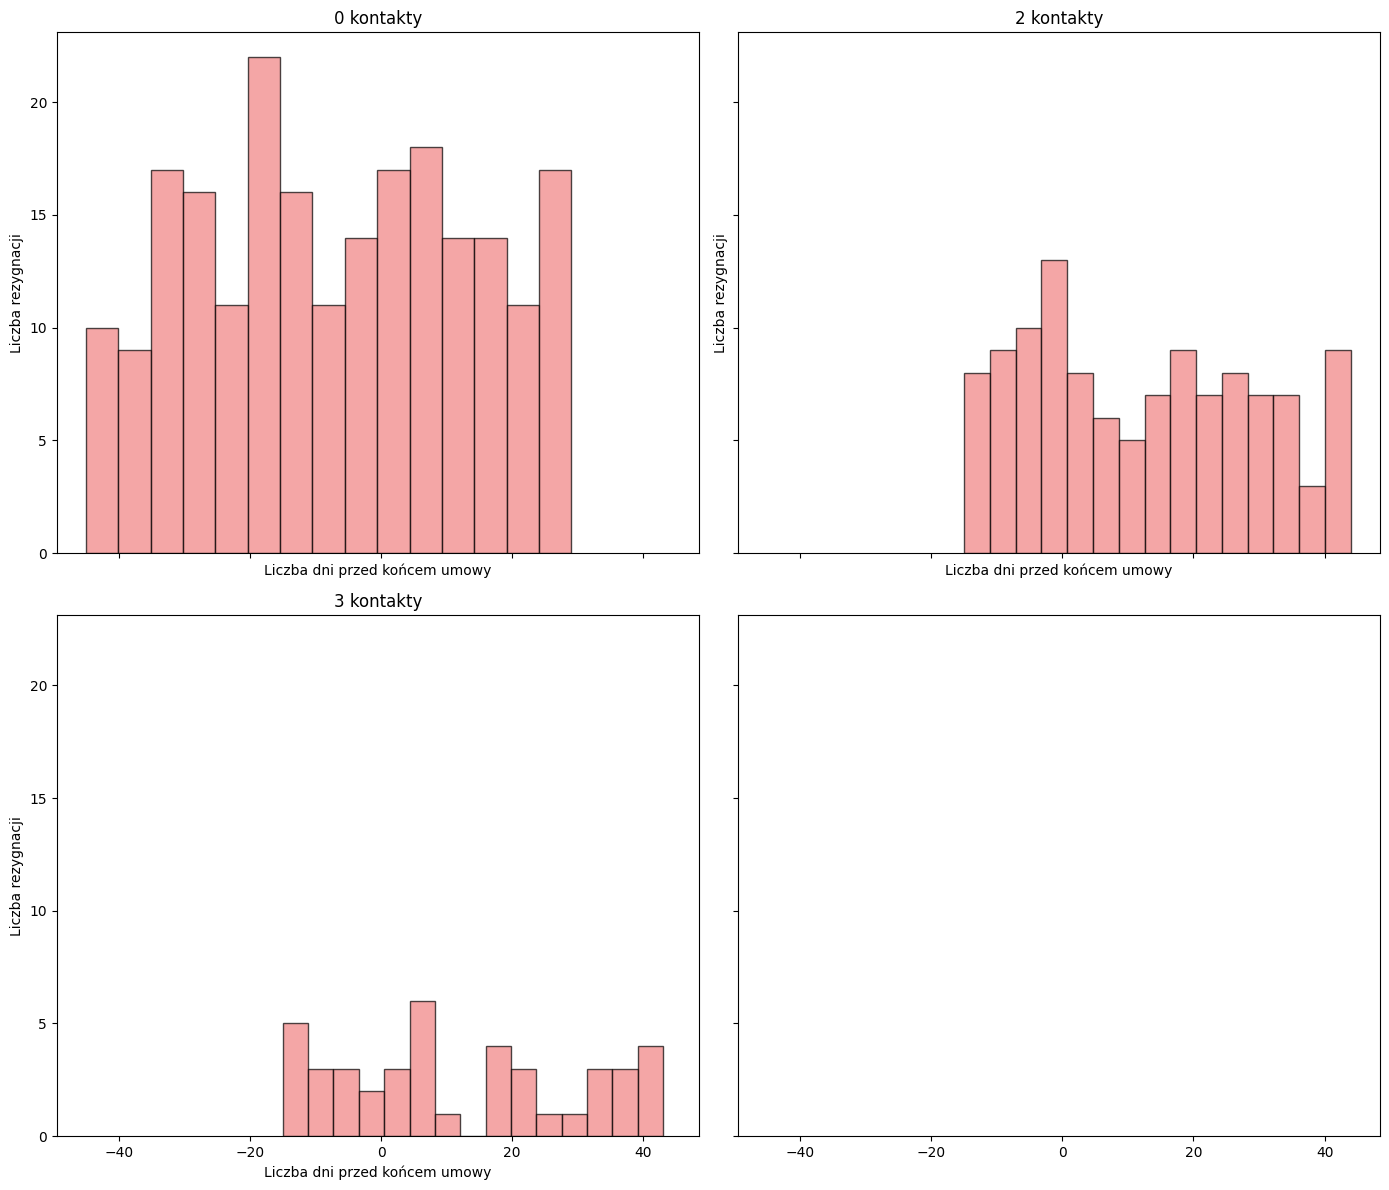

In [35]:
def count_contacts(row):
    return row[['contact TeleOut #1', 'contact sms #1', 'contact TeleOut #2']].notna().sum()

df['Number of Contacts'] = df.apply(count_contacts, axis=1)
df['Resigned'] = df['Resignation date'].notna()
df['Days to expire'] = (df['expiration date'] - df['Resignation date']).dt.days
resigned_customers_days = df[df['Resigned']]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12), sharex=True, sharey=True)
axes = axes.flatten()

contacts = resigned_customers_days['Number of Contacts'].unique()
contacts.sort()

for i, contact in enumerate(contacts):
    subset = resigned_customers_days[resigned_customers_days['Number of Contacts'] == contact]
    axes[i].hist(subset['Days to expire'], bins=15, color='lightcoral', edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{contact} kontakty')
    axes[i].set_xlabel('Liczba dni przed końcem umowy')
    axes[i].set_ylabel('Liczba rezygnacji')

plt.tight_layout()
plt.show()

1. Klienci bez kontaktów mają rozproszony rozkład, z rezygnacjami zarówno przed, jak i po terminie.
2. Klienci z dwoma kontaktami mają wyraźniejszy szczyt w okolicach terminu wygaśnięcia, z kilkoma rezygnacjami po terminie.
3. Klienci z trzema kontaktami również mają rozkład skoncentrowany wokół terminu wygaśnięcia, z pewnymi przypadkami rezygnacji po terminie.

In [36]:
resigned_customers_days['Number of Contacts'].value_counts()

Number of Contacts
0    217
2    116
3     42
Name: count, dtype: int64

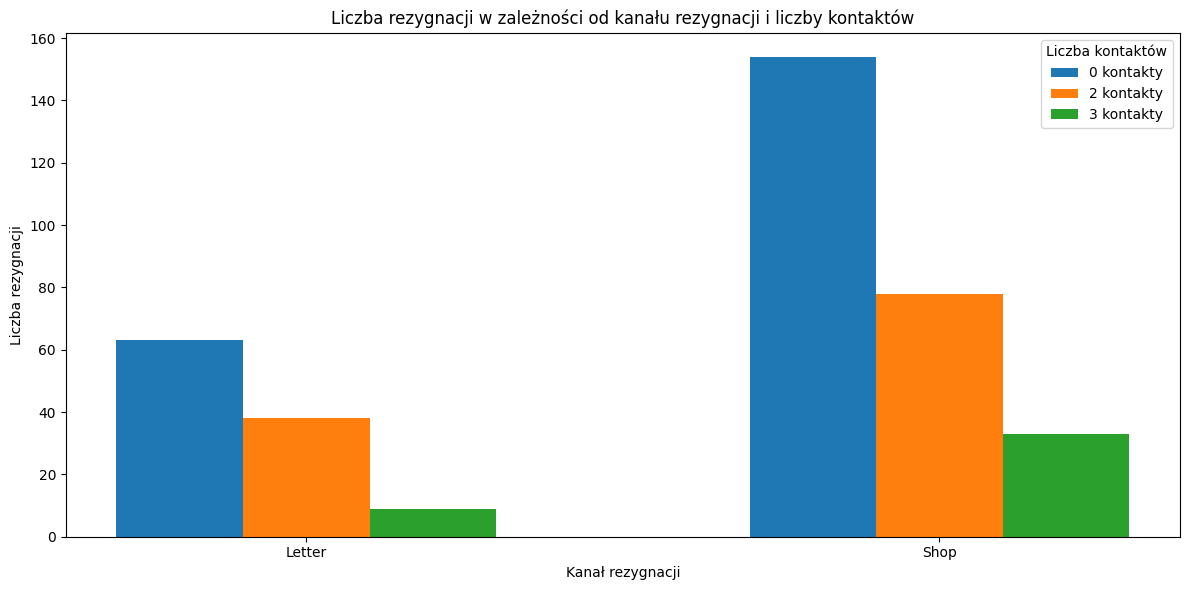

In [37]:
resignations_by_channel_and_contacts = resigned_customers_days.groupby(['Resignation channel', 'Number of Contacts']).size().reset_index(name='Count')

fig, ax = plt.subplots(figsize=(12, 6))

channels = resignations_by_channel_and_contacts['Resignation channel'].unique()
contacts = resignations_by_channel_and_contacts['Number of Contacts'].unique()

bar_width = 0.2
index = np.arange(len(channels))

for i, contact in enumerate(contacts):
    counts = resignations_by_channel_and_contacts[resignations_by_channel_and_contacts['Number of Contacts'] == contact]['Count']
    ax.bar(index + i * bar_width, counts, bar_width, label=f'{contact} kontakty')

ax.set_xlabel('Kanał rezygnacji')
ax.set_ylabel('Liczba rezygnacji')
ax.set_title('Liczba rezygnacji w zależności od kanału rezygnacji i liczby kontaktów')
ax.set_xticks(index + bar_width * (len(contacts) - 1) / 2)
ax.set_xticklabels(channels)
ax.legend(title='Liczba kontaktów')

plt.tight_layout()
plt.show()

In [38]:
df

,Customer id,customer value Jan-Mar23,expiration date,communication suspended,contact TeleOut #1,contact sms #1,contact TeleOut #2,Retention date,Retention Channel,Commission,value after retention,Resignation channel,Resignation date,Resigned,Days to expire,Number of Contacts
0,Cust #1,78.194893,2023-10-07 04:06:42.361,no,2023-05-18 21:33:46.638,2023-06-25 01:53:00.821,NaT,NaT,NaN,NaN,NaN,NaN,NaT,False,NaN,2
1,Cust #2,83.686783,2023-09-22 13:33:04.879,no,2023-05-22 02:30:22.388,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaT,False,NaN,1
2,Cust #3,81.190345,2023-09-12 22:26:36.266,no,2023-05-07 20:51:31.651,NaT,NaT,2023-09-22 01:40:35.814,Shop,124.853268,94.097896,NaN,NaT,False,NaN,1
3,Cust #4,90.560638,2023-10-09 12:37:59.097,no,NaT,2023-06-17 10:42:42.513,2023-08-08 16:53:44.974,NaT,NaN,NaN,NaN,Shop,2023-10-07 17:07:03.206,True,1.0,2
4,Cust #5,87.557485,2023-10-01 07:13:08.946,no,NaT,2023-06-07 19:21:56.337,2023-07-25 18:28:08.923,2023-09-14 18:11:34.154,TeleIn,120.179543,93.376548,NaN,NaT,False,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2265,Cust #2266,77.352726,2023-09-15 09:26:09.272,no,NaT,2023-06-03 12:14:32.542,2023-07-11 23:25:29.600,2023-09-07 06:55:08.726,Shop,184.060584,67.782142,NaN,NaT,False,NaN,2
2266,Cust #2267,79.706599,2023-09-27 03:21:17.987,no,NaT,2023-06-04 14:33:41.745,2023-06-29 18:05:54.950,2023-09-25 23:02:24.922,TeleOut,145.425290,88.611057,NaN,NaT,False,NaN,2
2267,Cust #2268,99.004738,2023-09-18 03:26:17.023,no,NaT,2023-05-28 03:10:17.334,2023-06-24 02:12:33.228,2023-09-14 05:18:38.623,www,110.562889,110.831920,NaN,NaT,False,NaN,2
2268,Cust #2269,83.657607,2023-09-14 13:40:10.104,no,NaT,2023-05-23 04:41:17.262,2023-07-11 10:27:22.950,2023-09-28 00:22:38.555,TeleOut,128.953957,95.197093,NaN,NaT,False,NaN,2


### Przedłużenie / nie przedłużenie umowy a ilosć kontaktów

In [46]:
# Grupujemy dane i liczymy ilość klientów dla każdej liczby kontaktów
customers_by_contacts = retained_customers['Number of Contacts'].value_counts().sort_index().reset_index()
customers_by_contacts.columns = ['Number of Contacts', 'Number of Customers']

# Obliczamy procent klientów
total_customers = customers_by_contacts['Number of Customers'].sum()
customers_by_contacts['Percent'] = (customers_by_contacts['Number of Customers'] / total_customers * 100).round(1)

# Tworzymy wykres
fig = go.Figure()

# Dodajemy słupki
fig.add_trace(go.Bar(
    x=customers_by_contacts['Number of Contacts'],
    y=customers_by_contacts['Number of Customers'],
    text=[f"{count} ({percent}%)" for count, percent in zip(customers_by_contacts['Number of Customers'], customers_by_contacts['Percent'])],
    textposition='auto',
    marker_color='lightblue',
    name='Liczba klientów'
))

# Aktualizacja układu wykresu
fig.update_layout(
    title_text='Liczba klientów, którzy przedłużyli umowę, w zależności od liczby kontaktów',
    xaxis_title='Liczba kontaktów',
    yaxis_title='Liczba klientów',
    height=600,
    width=1000
)

# Ustawienie osi X na wartości całkowite
fig.update_xaxes(tickmode='linear', tick0=0, dtick=1)

# Wyświetlenie wykresu
fig.show()


print(f"Całkowita liczba klientów, którzy przedłużyli umowę: {total_customers}")
for _, row in customers_by_contacts.iterrows():
    print(f"Liczba kontaktów: {row['Number of Contacts']}, Liczba klientów: {row['Number of Customers']} ({row['Percent']}%)")

Całkowita liczba klientów, którzy przedłużyli umowę: 1274
Liczba kontaktów: 0.0, Liczba klientów: 530.0 (41.6%)
Liczba kontaktów: 1.0, Liczba klientów: 84.0 (6.6%)
Liczba kontaktów: 2.0, Liczba klientów: 477.0 (37.4%)
Liczba kontaktów: 3.0, Liczba klientów: 183.0 (14.4%)


In [64]:
resigned_customers = df[df['Resignation date'].notna()]


customers_by_contacts = resigned_customers['Number of Contacts'].value_counts().sort_index().reset_index()
customers_by_contacts.columns = ['Number of Contacts', 'Number of Customers']

total_customers = customers_by_contacts['Number of Customers'].sum()
customers_by_contacts['Percent'] = (customers_by_contacts['Number of Customers'] / total_customers * 100).round(1)


fig = go.Figure()


fig.add_trace(go.Bar(
    x=customers_by_contacts['Number of Contacts'],
    y=customers_by_contacts['Number of Customers'],
    text=[f"{count} ({percent}%)" for count, percent in zip(customers_by_contacts['Number of Customers'], customers_by_contacts['Percent'])],
    textposition='auto',
    marker_color='salmon',  
    name='Liczba klientów'
))


fig.update_layout(
    title_text='Liczba klientów, którzy złożyli rezygnację, w zależności od liczby kontaktów',
    xaxis_title='Liczba kontaktów',
    yaxis_title='Liczba klientów',
    height=600,
    width=1000
)

fig.update_xaxes(tickmode='linear', tick0=0, dtick=1)
fig.show()

print(customers_by_contacts)
print("\nPodsumowanie:")
print(f"Całkowita liczba klientów, którzy złożyli rezygnację: {total_customers}")
for _, row in customers_by_contacts.iterrows():
    print(f"Liczba kontaktów: {row['Number of Contacts']}, Liczba klientów: {row['Number of Customers']} ({row['Percent']}%)")

   Number of Contacts  Number of Customers  Percent
0                   0                  217     57.9
1                   2                  116     30.9
2                   3                   42     11.2

Podsumowanie:
Całkowita liczba klientów, którzy złożyli rezygnację: 375
Liczba kontaktów: 0.0, Liczba klientów: 217.0 (57.9%)
Liczba kontaktów: 2.0, Liczba klientów: 116.0 (30.9%)
Liczba kontaktów: 3.0, Liczba klientów: 42.0 (11.2%)


In [76]:
fig = px.scatter(df, x='customer value Jan-Mar23', y='value after retention',
                 title='Porównanie wartości klienta przed i po retencji',
                 labels={'customer value Jan-Mar23': 'Wartość przed retencją',
                         'value after retention': 'Wartość po retencji'},
                 trendline='ols')
fig.add_shape(type='line', x0=0, y0=0, x1=1, y1=1, xref='paper', yref='paper',
              line=dict(color='red', dash='dash'))
fig.show()

Efektywność kontaktów:

Wśród klientów, którzy przedłużyli umowę, znacząca część (51.8%) miała co najmniej jeden kontakt (37.4% miało 2 kontakty, 14.4% miało 3 kontakty).
Dla porównania, wśród klientów, którzy złożyli rezygnację, mniejszy odsetek (42.1%) miał kontakty.



In [62]:
import pandas as pd
import plotly.graph_objects as go

def first_contact_type(row):
    if pd.notnull(row['contact TeleOut #1']) and pd.notnull(row['contact sms #1']):
        return 'TeleOut' if row['contact TeleOut #1'] < row['contact sms #1'] else 'SMS'
    elif pd.notnull(row['contact TeleOut #1']):
        return 'TeleOut'
    elif pd.notnull(row['contact sms #1']):
        return 'SMS'
    else:
        return 'Brak kontaktu'


def count_contacts(row):
    return sum(pd.notnull(row[col]) for col in ['contact TeleOut #1', 'contact sms #1', 'contact TeleOut #2'])


df['First Contact'] = df.apply(first_contact_type, axis=1)
df['Contact Count'] = df.apply(count_contacts, axis=1)

df_filtered = df[df['Contact Count'] >= 2]
df_filtered['Status'] = 'Brak decyzji'
df_filtered.loc[df_filtered['Retention date'].notna(), 'Status'] = 'Przedłużenie'
df_filtered.loc[df_filtered['Resignation date'].notna(), 'Status'] = 'Rezygnacja'

grouped = df_filtered.groupby(['First Contact', 'Status']).size().unstack(fill_value=0)
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100


fig = go.Figure()
fig.add_trace(go.Bar(
    x=grouped_percent.index,
    y=grouped_percent['Przedłużenie'],
    name='Przedłużenie',
    text=[f"{val:.1f}%" for val in grouped_percent['Przedłużenie']],
    textposition='auto',
    marker_color='lightgreen'
))

fig.add_trace(go.Bar(
    x=grouped_percent.index,
    y=grouped_percent['Rezygnacja'],
    name='Rezygnacja',
    text=[f"{val:.1f}%" for val in grouped_percent['Rezygnacja']],
    textposition='auto',
    marker_color='salmon'
))


fig.update_layout(
    title_text='Porównanie efektywności kanału pierwszego kontaktu (dla klientów z co najmniej 2 kontaktami)',
    xaxis_title='Typ pierwszego kontaktu',
    yaxis_title='Procent klientów',
    barmode='stack',
    height=600,
    width=1000
)


fig.show()

TeleOut jako kanał pierwszego kontaktu ma nieznacznie wyższy wskaźnik skuteczności (stosunek przedłużeń do rezygnacji 4.26) w porównaniu do SMS (3.72).

In [63]:
grouped

Status,Brak decyzji,Przedłużenie,Rezygnacja
First Contact,,,
SMS,0,93,25
TeleOut,59,567,133


In [65]:
resigned_without_contact = df[(df['Resignation date'].notna()) & 
                              (df['contact TeleOut #1'].isnull()) & 
                              (df['contact sms #1'].isnull()) & 
                              (df['contact TeleOut #2'].isnull())]

In [66]:
value_analysis = resigned_without_contact['customer value Jan-Mar23'].describe()
print(value_analysis)

count    217.000000
mean      85.560411
std        8.134895
min       70.699940
25%       78.587369
50%       85.481659
75%       92.010923
max       99.928996
Name: customer value Jan-Mar23, dtype: float64


In [68]:
resignation_by_month = resigned_without_contact['Resignation date'].dt.month.value_counts().sort_index()
print(resignation_by_month)

Resignation date
8     21
9     79
10    91
11    26
Name: count, dtype: int64


In [71]:
extended_without_contact = df[(df['Retention date'].notna()) & 
                              (df['contact TeleOut #1'].isnull()) & 
                              (df['contact sms #1'].isnull()) & 
                              (df['contact TeleOut #2'].isnull())]

comparison = pd.DataFrame({
    'Rezygnacjas': resigned_without_contact['customer value Jan-Mar23'].describe(),
    'Przedłużenie': extended_without_contact['customer value Jan-Mar23'].describe()
})
print(comparison)

       Rezygnacjas  Przedłużenie
count   217.000000    530.000000
mean     85.560411     85.326933
std       8.134895      8.666666
min      70.699940     70.019804
25%      78.587369     78.044090
50%      85.481659     85.504740
75%      92.010923     92.893192
max      99.928996     99.994592


Brak znaczących różnic w wartościach klientów między grupami sugeruje, że sama wartość klienta nie jest kluczowym czynnikiem wpływającym na decyzję o rezygnacji lub przedłużeniu umowy bez kontaktu. Grupa rezygnujących jest znacznie mniejsza, co może świadczyć o skuteczności ogólnej strategii retencji.

In [73]:
# porównanie klientów którzy zrezygnowali tych bez kontaktu vs tych którzy mieli kontakt
resigned_with_contact = df[(df['Resignation date'].notna()) & 
                           ((df['contact TeleOut #1'].notna()) | 
                            (df['contact sms #1'].notna()) | 
                            (df['contact TeleOut #2'].notna()))]

comparison = pd.DataFrame({
    'Bez kontaktu': resigned_without_contact['customer value Jan-Mar23'].describe(),
    'Z kontaktem': resigned_with_contact['customer value Jan-Mar23'].describe()
})
print(comparison)

       Bez kontaktu  Z kontaktem
count    217.000000   158.000000
mean      85.560411    84.781030
std        8.134895     8.745424
min       70.699940    70.595984
25%       78.587369    76.799582
50%       85.481659    85.430942
75%       92.010923    91.599774
max       99.928996    99.458909
